# Train Model

Text

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import shap
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## Define Variables

In [2]:
WINDOW = 90
RANDOM_STATE = 42

In [3]:
# Load train dataframe
df_train = pd.read_parquet('../data/processed/df_easternmountain_train.parquet.gzip')
df_train['time'] = pd.to_datetime(df_train['time'])

# Load validate dataframe
df_validate = pd.read_parquet('../data/processed/df_easternmountain_validate.parquet.gzip')
df_validate['time'] = pd.to_datetime(df_validate['time'])

# Load test dataframe
df_test = pd.read_parquet('../data/processed/df_easternmountain_test.parquet.gzip')
df_test['time'] = pd.to_datetime(df_test['time'])

# Load project dataframe
df_project = pd.read_parquet('../data/processed/df_easternmountain_project.parquet.gzip')
df_project['time'] = pd.to_datetime(df_project['time'])

## Define Functions

In [4]:
def preprocess_data(df_train, df_validate, augment=False, rolling=False, window=90):
    """
    Preprocess the training and validation dataframes.

    Parameters:
    - df_train (pd.DataFrame): DataFrame containing the training data.
    - df_validate (pd.DataFrame): DataFrame containing the validation data.
    - augment (bool): Boolean flag to indicate whether data augmentation should be applied.
    - rolling (bool): Boolean flag to indicate whether a rolling window transformation should be applied.
    - window (int): The size of the rolling window (in days).

    Returns:
    - A tuple of pd.DataFrames.
    """
    # Create a copy of the DataFrames to avoid modifying the originals
    df_train_processed = df_train.copy()
    df_validate_processed = df_validate.copy()

    if rolling:
        # Apply rolling window to the training data
        df_train_processed = to_rolling(df_train_processed, window=window)

        # Concatenate training and validation dataframes and apply rolling window
        df_concat = pd.concat([df_train, df_validate]).reset_index(drop=True)
        df_concat = df_concat[df_concat['time'] > pd.to_datetime(df_train['time'].max()) - pd.Timedelta(days=window)]
        df_validate_processed = to_rolling(df_concat, window=window)

    if augment:
        # Add a 'month' column based on the 'time' column to both dataframes
        df_train_processed.insert(3, 'month', df_train_processed['time'].dt.month)
        df_validate_processed.insert(3, 'month', df_validate_processed['time'].dt.month)

    # Return the processed dataframes
    return df_train_processed, df_validate_processed


In [5]:
def to_rolling(df, window=90):
    """
    Converts the data in a given DataFrame to a rolling mean for each coordinate separately,
    with a specified window size. The function groups data by latitude and longitude coordinates,
    sorts by time within each group, and then applies a rolling mean operation. It returns a
    DataFrame and preserves the original order of columns.

    Parameters:
    - df (pd.DataFrame): The input DataFrame to be processed. It must contain 'lat' (latitude),
      'lon' (longitude), and 'time' columns. 'lat' and 'lon' are used for grouping and 'time' for
      sorting within each group and performing rolling operations.
    - window (int): The window size for the rolling mean calculation, with a default of 90.

    Returns:
    - pd.DataFrame: A DataFrame after applying a rolling mean operation on the data for each
      coordinate, dropping rows with NA values.
    """
    # Ensure 'time' column is in datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    # Sort the DataFrame by 'time' to ensure correct rolling window application
    df.sort_values(by=['time'], inplace=True)
    
    # Group by 'lat' and 'lon', then apply rolling mean within each group
    df_rolling = df.groupby(['lat', 'lon'], as_index=False).rolling(window, on='time').mean()
    df_rolling = df_rolling.dropna().reset_index(drop=True)
    
    return df_rolling


In [39]:
def get_arrays(df, target=True):
    """
    Extracts features, target variable, spatial coordinates, and dates from a DataFrame.
    
    This function modifies a copy of the input DataFrame, extracting columns for spatial coordinates ('lat', 'lon'),
    dates ('time'), and the target variable ('fahrenheit'). The remaining columns are considered feature variables.

    Parameters:
    - df (pd.DataFrame): The input DataFrame from which to extract the data. The DataFrame should contain columns for
      latitude ('lat'), longitude ('lon'), time ('time'), various model scenarios, and a target variable ('fahrenheit').
    
    Returns:
    - tuple: A tuple containing the extracted data in the following order:
        - X (pd.DataFrame): A DataFrame of the feature variables, represented by the remaining model scenario columns
          after 'lat', 'lon', 'time', and 'fahrenheit' have been removed.
        - y (pd.Series): The target variable, extracted from the 'fahrenheit' column.
        - time (pd.Series): The date values, extracted from the 'time' column.
        - features (pd.Index): The names of the columns that are considered feature variables.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()
    
    # Extract columns from the DataFrame using the pop method
    time = df.pop('time')
    if target:
        y = df.pop('fahrenheit')
    else:
        y = None

    # The remaining DataFrame now consists only of the feature variables
    X = df
    features = X.columns

    return X, y, time, features


In [7]:
def train_single_model(df_train, df_validate, model):
    """
    Train a machine learning model using the provided training and validation dataframes.

    This function preprocesses the input dataframes to extract feature arrays and labels,
    scales the features using standard scaling, fits the model on the scaled training data,
    and then evaluates it using both the training and validation data. It calculates the
    root mean squared error (RMSE) and the R-squared (R2) value for both datasets.

    Parameters:
    - df_train: A pandas DataFrame containing the training data.
    - df_validate: A pandas DataFrame containing the validation data.
    - model: A scikit-learn compatible model that implements the .fit() and .predict() methods.

    Returns:
    - model: The trained machine learning model.
    - results: A dictionary containing the RMSE and R2 scores for the training and validation sets.
    """
    # Extract features and labels from training and validation data
    X_train, y_train, _, _ = get_arrays(df_train)
    X_validate, y_validate, _, _ = get_arrays(df_validate)

    # Scale features to have mean=0 and variance=1
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_validate_scaled = scaler.transform(X_validate)

    # Fit the model to the scaled training data
    model = model.fit(X_train_scaled, y_train)

    # Predict on the scaled training and validation data
    preds_train = model.predict(X_train_scaled)
    preds_validate = model.predict(X_validate_scaled)

    # Calculate performance metrics
    results = {
        'rmse_train': mean_squared_error(y_train, preds_train) ** 0.5,
        'r2_train': r2_score(y_train, preds_train),
        'rmse_validate': mean_squared_error(y_validate, preds_validate) ** 0.5,
        'r2_validate': r2_score(y_validate, preds_validate)
    }

    return model, results, scaler


In [8]:
def train_multiple_models(df_train, df_validate, model):
    """
    Trains a specified machine learning model for each unique latitude and longitude pair 
    found in the training data.

    Parameters:
    - df_train (pd.DataFrame): DataFrame containing the training data, expected to include 
      'lat' and 'lon' columns for latitude and longitude, respectively.
    - df_validate (pd.DataFrame): DataFrame containing the validation data, also expected 
      to include 'lat' and 'lon' columns.
    - model (Any): An instance of a machine learning model that supports the fit and predict 
      methods. This model will be trained on the data for each latitude and longitude pair.

    Returns:
    - models (list): A list of trained machine learning model instances, one for each unique 
      latitude and longitude pair.
    - df_results (pd.DataFrame): A DataFrame containing the latitude and longitude of each 
      location, along with the corresponding training and validation RMSE (Root Mean Squared Error) 
      and R2 (coefficient of determination) metrics.
    """
    # Extract coordinates from training data
    coords = df_train[['lat', 'lon']]

    # Remove duplicate
    coords = coords.drop_duplicates()
    lats = coords['lat'].to_list()
    lons = coords['lon'].to_list()

    models = []
    results = {}

    for lat, lon in zip(lats, lons):

        metrics = {}

        # Filter dataframes for the current coordinates
        df_train_filtered = df_train[(df_train['lat'] == lat) & (df_train['lon'] == lon)]
        df_validate_filtered = df_validate[(df_validate['lat'] == lat) & (df_validate['lon'] == lon)]

        # Extract arrays for model training and validation
        X_train, y_train, _, _ = get_arrays(df_train_filtered)
        X_validate, y_validate, _, _ = get_arrays(df_validate_filtered)
            
        # Fit the model and predict
        model.fit(X_train, y_train)
        preds_train = model.predict(X_train)
        preds_validate = model.predict(X_validate)

        # Calculate performance metrics
        metrics = {
            'rmse_train': mean_squared_error(y_train, preds_train) ** 0.5,
            'r2_train': r2_score(y_train, preds_train),
            'rmse_validate': mean_squared_error(y_validate, preds_validate) ** 0.5,
            'r2_validate': r2_score(y_validate, preds_validate)
        }

        models.append(model)
        results[(lat, lon)] = metrics

    # Convert results to DataFrame
    df_results = pd.DataFrame(results).transpose().reset_index()
    df_results = df_results.rename(columns={'level_0': 'lat', 'level_1': 'lon'})

    return models, df_results


In [9]:
def plot_spatial_results(df, lat='lat', lon='lon', value='rmse'):
    """
    Plots geographic results on a scatter map using Plotly Express.

    This function creates a scatter geo plot of the given DataFrame. It maps 'lat' and 'lon'
    as coordinates, and uses 'rmse' for both color and size scaling of the points.

    Parameters:
    - df (pd.DataFrame): A pandas DataFrame containing the columns 'lat', 'lon', and 'rmse'.

    Returns:
    - None
    """
    fig = px.scatter_geo(
        df,
        lat=lat,
        lon=lon,
        color=value,
        size=value,
        size_max=15,
        projection='albers usa',
        fitbounds='locations'
    )

    fig.update_layout(dragmode=False)

    fig.show()


In [10]:
def plot_temporal_results(df, model, scaler):
    """
    Plots average temporal predictions along with actual values on a line graph.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the features and actual values.
    - model (Any): Trained model used to make predictions.
    - scaler (Any): Pre-fitted scaler used for transforming the features.

    Returns:
    None
    """
    # Create a copy of the DataFrame to avoid modifying the original data
    df = df.copy()

    # Extract and scale features
    X, _, _, _ = get_arrays(df)
    X_scaled = scaler.transform(X)

    # Add predictions to the DataFrame
    df['preds'] = model.predict(X_scaled)

    # Compute the average of actual and predicted values
    results = df.groupby('time')[['fahrenheit', 'preds']].mean().reset_index()

    # Plot the results using a line graph
    fig = px.line(results, x='time', y=['fahrenheit', 'preds'])
    fig.show()


## Explore Data

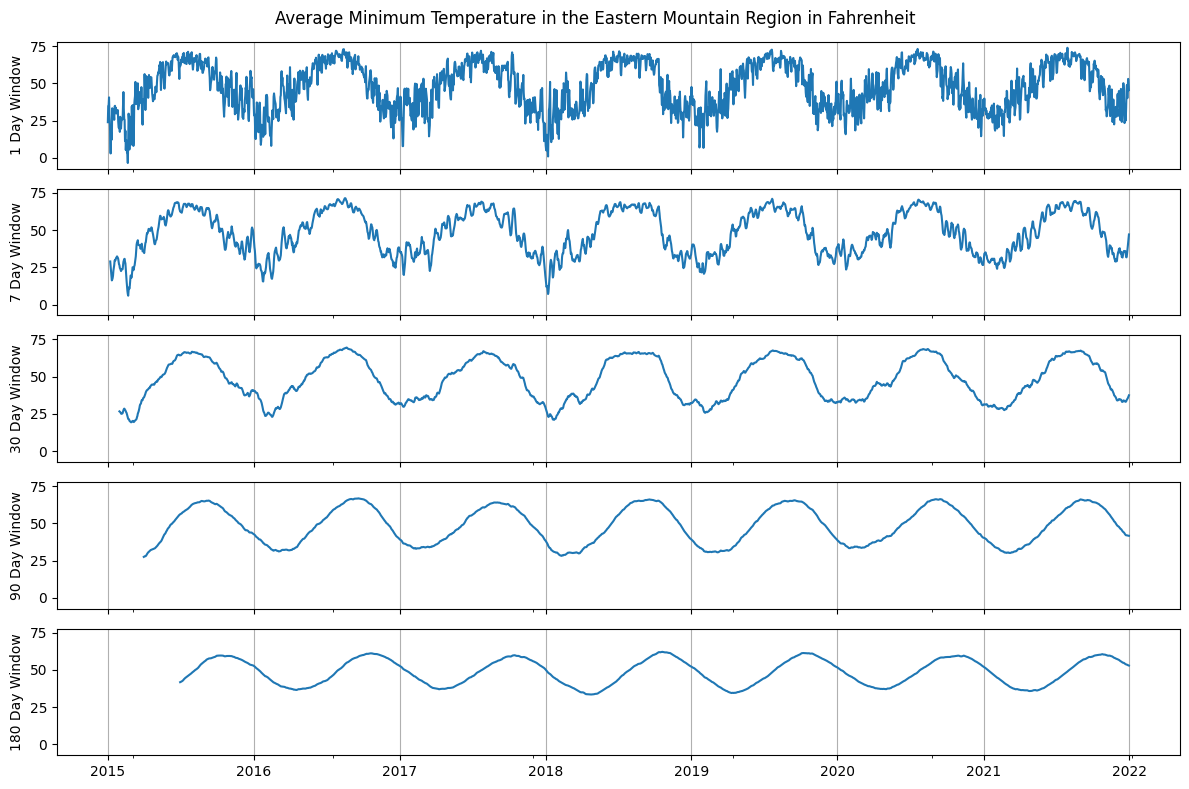

In [11]:
# Calculate the average minimum temperature for each time point
data = df_train.groupby('time').mean().iloc[:, -1].reset_index()
data['time'] = pd.to_datetime(data['time'])

windows = [1, 7, 30, 90, 180]

# Create subplots for each rolling window size
fig, axs = plt.subplots(
    nrows=len(windows), 
    ncols=1, 
    figsize=(12, 8), 
    sharex=True, 
    sharey=True, 
    tight_layout=True
)

# Plot the rolling average for each window size
for i, window in enumerate(windows):
    rolling_data = data.set_index('time').rolling(window).mean()
    rolling_data.plot(ax=axs[i], legend=False)
    axs[i].set_xlabel('')
    axs[i].set_ylabel(f'{window} Day Window')
    axs[i].grid(visible=True, axis='x')

# Set the overall figure title
fig.suptitle('Average Minimum Temperature in the Eastern Mountain Region in Fahrenheit')

# Center-align the x-axis labels of the last subplot
axs[-1].tick_params(axis='x', rotation=0)  # Ensure labels are not rotated
for label in axs[-1].get_xticklabels():
    label.set_horizontalalignment('center')

plt.show()

# fig.savefig('../reports/figures/rolling_average_easternmountain.png')

## Train Model

### Establish Baseline

Averaging across the models yields an r2 value of 0.71 for the train dataframe and 0.74 for the validate dataframe.

In [12]:
# Process data
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate)
X_train, y_train, time_train, features_train = get_arrays(df_train_processed)
lat_train = X_train.pop('lat')
lon_train = X_train.pop('lon')
X_validate, y_validate, time_validate, features_validate = get_arrays(df_validate_processed)
lat_validate = X_validate.pop('lat')
lon_validate = X_validate.pop('lon')

# Average across models and scenarios
print('rmse_train:', mean_squared_error(y_train, X_train.mean(axis=1)) ** 0.5)
print('r2_train:', r2_score(y_train, X_train.mean(axis=1)))
print('rmse_validate:', mean_squared_error(y_validate, X_validate.mean(axis=1)) ** 0.5)
print('r2_validate:', r2_score(y_validate, X_validate.mean(axis=1)))

rmse_train: 8.514413823373532
r2_train: 0.7147640978163672
rmse_validate: 8.553645431074402
r2_validate: 0.7366746058609224


Averaging across the models with rolling yields an r2 value of 0.94 for the train dataframe and 0.97 for the validate dataframe.

In [13]:
# Process rolling data
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate, rolling=True, window=WINDOW)
X_train, y_train, time_train, features_train = get_arrays(df_train_processed)
lat_train = X_train.pop('lat')
lon_train = X_train.pop('lon')
X_validate, y_validate, time_validate, features_validate = get_arrays(df_validate_processed)
lat_validate = X_validate.pop('lat')
lon_validate = X_validate.pop('lon')

# Average across models and scenarios
print('rmse_train:', mean_squared_error(y_train, X_train.mean(axis=1)) ** 0.5)
print('r2_train:', r2_score(y_train, X_train.mean(axis=1)))
print('rmse_validate:', mean_squared_error(y_validate, X_validate.mean(axis=1)) ** 0.5)
print('r2_validate:', r2_score(y_validate, X_validate.mean(axis=1)))

rmse_train: 3.12427566006402
r2_train: 0.935440564856465
rmse_validate: 2.283314934248458
r2_validate: 0.9664521057492681


### Ordinary Least Squares Regression

#### Single Model

Training a single ordinarly least squares model with rolling yields an r2 value of 0.99 for the train dataframe and 0.95 for the validate dataframe. This model is less successful than the rolling baseline. It overfits the train dataframe and underfits the validate dataframe.

In [14]:
# Process data
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate, rolling=True, window=90)

# Instantiate a model
ols = LinearRegression()

# Train a single model and assess performance
_, results, _ = train_single_model(df_train_processed, df_validate_processed, ols) 
results

{'rmse_train': 0.9961984596621963,
 'r2_train': 0.9934362389438177,
 'rmse_validate': 2.7526370933299726,
 'r2_validate': 0.9512436094913462}

Training a single ordinarly least squares model with augmentation and rolling yields an r2 value of 0.99 for the train dataframe and 0.95 for the validate dataframe. This model is less successful than the rolling baseline. It overfits the train dataframe and underfits the validate dataframe.

In [15]:
# Process data
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate, augment=True, rolling=True, window=WINDOW)

# Instantiate a model
ols = LinearRegression()

# Train a single model and assess performance
_, results, _ = train_single_model(df_train_processed, df_validate_processed, ols) 
results

{'rmse_train': 0.9930021652820373,
 'r2_train': 0.9934782909180156,
 'rmse_validate': 2.669462440402541,
 'r2_validate': 0.9541455741153771}

#### Multiple Models

Training multiple ordinarly least squares models with rolling yields an r2 value of 1.00 for the train dataframe and 0.92 for the validate dataframe. These models are less successful than the rolling baseline. They overfit the train dataframe and underfit the validate dataframe.

In [16]:
# Process data
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate, rolling=True, window=WINDOW)

# Instantiate a model
ols = LinearRegression()

# Train a model for each coordinate and assess performance
_, results = train_multiple_models(df_train_processed, df_validate_processed, ols)
results.iloc[:, 2:].mean()

rmse_train       0.489580
r2_train         0.998355
rmse_validate    3.384113
r2_validate      0.922397
dtype: float64

### Elastic-Net Regression

#### Single Model

Training a single elastic-net model with rolling yields an r2 value of 0.98 for the train dataframe and 0.97 for the validate dataframe. This model outperforms the rolling baseline. It fits both the train dataframe and the validate dataframe. However, there is variability at the coordinate level, with r2 values ranging from 0.93 to 0.99 for the validate dataframe. The most variable coordinates appear over the Appalachian Mountains, on the border between Virginia and West Virginia.

In [17]:
# Process data
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate, rolling=True, window=90)

# Instantiate a model
eln = ElasticNet(alpha=1.0, max_iter=10000, positive=True, random_state=RANDOM_STATE)

# Train a single model and assess performance
model, results, scaler = train_single_model(df_train_processed, df_validate_processed, eln) 
results

{'rmse_train': 1.8061482160816038,
 'r2_train': 0.9784241554687156,
 'rmse_validate': 2.200119834487233,
 'r2_validate': 0.968852277020712}

In [18]:
# Assess temporal performance
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate, rolling=True, window=WINDOW)
plot_temporal_results(pd.concat([df_train_processed, df_validate_processed]), model, scaler)

In [19]:
# Get arrays
X_validate, _, _, features_validate = get_arrays(df_validate_processed)
X_validate_scaled = scaler.transform(X_validate)

# Add predictions to dataframe
df_validate_processed['preds'] = model.predict(X_validate_scaled)

# Assess spatial performance
single_model_results = df_validate_processed.groupby(
        ['lat', 'lon']
    ).apply(
        lambda x: pd.Series({
            'rmse': mean_squared_error(x['fahrenheit'], x['preds']) ** 0.5,
            'r2': r2_score(x['fahrenheit'], x['preds'])
        }), include_groups=False
    ).reset_index(
    ).sort_values('r2', ascending=False)

# Plot results
plot_spatial_results(single_model_results, lat='lat', lon='lon', value='rmse')

#### Multiple Models

Training multiple elastic-net models with rolling yields an r2 value of 0.99 for the train dataframe and 0.98 for the validate dataframe. These models are more successful than the rolling baseline and marginally more successful than the single elastic-net model with rolling.

At the coordinate level, the multiple model approach yields r2 values between 0.97 and 0.99. For reference, the difference between an r2 value of 0.93 (from the single model approach) and 0.97 (from the multiple model approach) is just over one degree fahrenheit. Like the single model, the most variable regions appear to be in the Appalachian Mountains, on the border between Virginia and West Virginia. However, there is also variability over the Blue Ridge Mountains in North Carolina. This suggests an elevation feature might improve model performance.

In [20]:
# Process data
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate, rolling=True, window=90)

# Instantiate a model
eln = ElasticNet(alpha=1.0, max_iter=10000, positive=True, random_state=RANDOM_STATE)

# Train a model for each coordinate and assess performance
_, results = train_multiple_models(df_train_processed, df_validate_processed, eln)
results.iloc[:, 2:].mean()

rmse_train       1.084221
r2_train         0.992013
rmse_validate    1.744252
r2_validate      0.979588
dtype: float64

In [21]:
# Assess spatial performance
multiple_model_results = results.sort_values('r2_validate', ascending=False)

# Plot results
plot_spatial_results(multiple_model_results, lat='lat', lon='lon', value='rmse_validate')

## Evaluate Model

### Evaluate Features

Although certain model-scenario combinations are more influential than others, all combinations contribute to the predictive power of the elastic-net model, as indicated by SHapley Additive exPlanations (SHAP). Coefficients range from 0.0 for latitude and longitude to just over 0.3 for GFDL-ESM4-SSP585.

In [22]:
# Process data
df_train_processed, df_validate_processed = preprocess_data(df_train, df_validate, rolling=True, window=WINDOW)

# Instantiate a model
eln = ElasticNet(alpha=1.0, max_iter=10000, positive=True, random_state=RANDOM_STATE)

# Train a single model
model, _, scaler = train_single_model(df_train_processed, df_validate_processed, eln) 

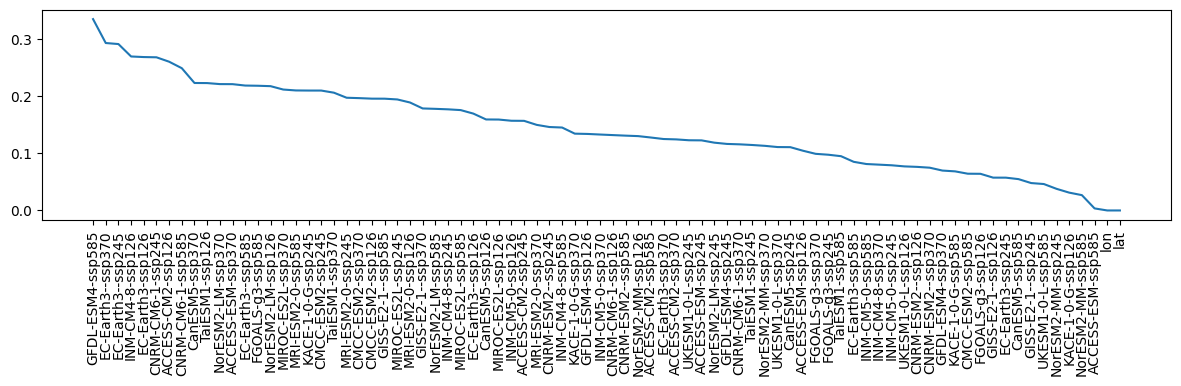

In [23]:
# Retrieve weights
X, _, _, features = get_arrays(df_train_processed)
coefs = pd.DataFrame(model.coef_, index=features_validate, columns=['coef']).sort_values('coef', ascending=False)

# Plot weights
fig, axs = plt.subplots(figsize=(12, 4))
axs.plot(coefs)
axs.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

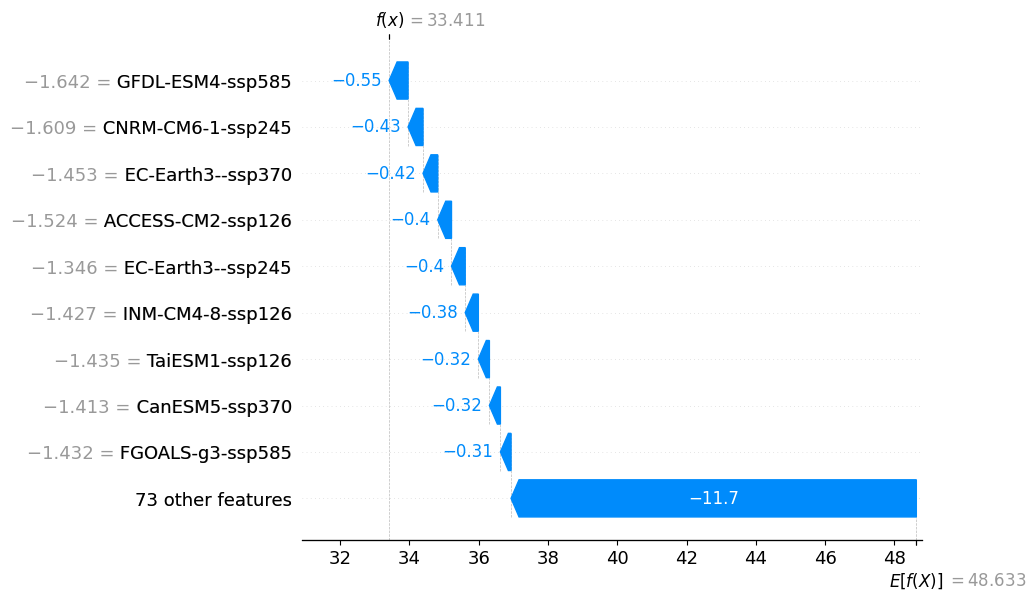

In [24]:
# Plot SHapley Additive exPlanations (SHAP)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)
explainer = shap.explainers.Linear(model, X_scaled)
shap_values = explainer(X_scaled)
shap.plots.waterfall(shap_values[0])

### Evaluate Final Model

In [25]:
# Process data
df_concat = pd.concat([df_train, df_validate]).reset_index(drop=True)
df_train_processed, df_test_processed = preprocess_data(df_concat, df_test, rolling=True, window=WINDOW)

# Instantiate a model
eln = ElasticNet(alpha=1.0, max_iter=10000, positive=True, random_state=RANDOM_STATE)

# Train a single model
model, results, scaler = train_single_model(df_train_processed, df_test_processed, eln)

Averaging across the models with rolling, combining the train and validate dataframes, yields an r2 value of 0.94 for the combined dataframe and 0.90 for the test dataframe.

In [26]:
# Get arrays
X_train, y_train, _, _ = get_arrays(df_train_processed)
X_test, y_test, _, _ = get_arrays(df_test_processed)

# Assess performance
print('rmse_train:', mean_squared_error(y_train, X_train.iloc[:, 2:].mean(axis=1)) ** 0.5)
print('r2_train:', r2_score(y_train, X_train.iloc[:, 2:].mean(axis=1)))
print('rmse_test:', mean_squared_error(y_test, X_test.iloc[:, 2:].mean(axis=1)) ** 0.5)
print('r2_test:', r2_score(y_test, X_test.iloc[:, 2:].mean(axis=1)))

rmse_train: 3.028878441444726
r2_train: 0.939613406139479
rmse_test: 3.4482150305799593
r2_test: 0.8994982073327261


Training a single elastic-net model with rolling yields an r2 value of 0.98 for the combined train and validate dataframe and 0.96 for the test dataframe. This model outperforms the updated rolling baseline.

In [27]:
results

{'rmse_train': 1.843565306643389,
 'r2_train': 0.9776285620913466,
 'rmse_validate': 2.2087817157660385,
 'r2_validate': 0.9587626523214062}

## Predict Temperature

In [80]:
# Process data
_, df_project_processed = preprocess_data(df_test.iloc[:, :-1], df_project, rolling=True, window=WINDOW)

# Get arrays
X, _, time, _ = get_arrays(df_project_processed, target=False)

# Scale features
X_scaled = scaler.transform(X)

# Predict temperature
preds = model.predict(X_scaled)

In [75]:
df_predict = pd.DataFrame({
    'time': time,
    'lat': X['lat'],
    'lon': X['lon'],
    'preds': preds,
})

In [84]:
df_project_processed

,lat,lon,time,ACCESS-CM2-ssp126,ACCESS-CM2-ssp245,ACCESS-CM2-ssp370,ACCESS-CM2-ssp585,ACCESS-ESM-ssp126,ACCESS-ESM-ssp245,ACCESS-ESM-ssp370,...,NorESM2-MM-ssp370,NorESM2-MM-ssp585,TaiESM1-ssp126,TaiESM1-ssp245,TaiESM1-ssp370,TaiESM1-ssp585,UKESM1-0-L-ssp126,UKESM1-0-L-ssp245,UKESM1-0-L-ssp370,UKESM1-0-L-ssp585
0,35.25,-83.25,2024-01-01,43.200378,38.385127,43.035846,39.526642,34.436080,30.281033,29.945087,...,42.721138,41.572477,36.634763,34.536089,35.011078,39.940591,37.008213,41.256271,36.329236,36.493459
1,35.25,-83.25,2024-01-02,43.102965,38.100975,42.629807,39.344146,34.176219,29.761018,29.981808,...,42.483811,41.363398,36.296199,34.249806,35.199939,39.596272,36.615538,40.941955,35.827899,36.242975
2,35.25,-83.25,2024-01-03,42.879583,37.765156,42.272118,38.762166,33.897425,29.185332,29.975467,...,42.237108,41.083774,35.949293,33.966826,35.265825,39.298849,36.218859,40.621289,35.405686,36.115672
3,35.25,-83.25,2024-01-04,42.659561,37.660970,42.066838,38.069572,33.731226,28.598083,29.756556,...,42.062374,40.961501,35.582302,33.853781,35.239026,39.043300,35.852973,40.505714,35.199379,36.023786
4,35.25,-83.25,2024-01-05,42.279234,37.563667,41.896459,37.598927,33.824349,28.065939,29.564989,...,41.687407,40.655421,35.300127,33.798481,35.319936,38.834551,35.587600,40.380877,34.727656,35.819129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,39.25,-78.00,2024-01-26,35.836492,32.672339,37.255957,31.812290,34.500219,26.938611,30.476106,...,33.789090,30.500876,32.009707,28.580264,32.949569,33.924273,31.629963,36.578708,31.842577,38.367300
2066,39.25,-78.00,2024-01-27,35.591342,32.551687,36.962842,31.469584,34.130488,26.793222,30.666474,...,33.416224,30.363635,31.628940,28.039174,32.930070,33.635388,31.403699,36.218457,31.516236,38.037236
2067,39.25,-78.00,2024-01-28,35.536734,32.481805,36.850799,30.923168,33.798903,26.708077,30.765898,...,33.186762,30.308767,31.220741,27.689954,32.854857,33.255353,31.269057,35.751234,31.331773,37.778337
2068,39.25,-78.00,2024-01-29,35.292116,32.290816,36.890803,30.345013,33.593811,26.662427,30.767989,...,32.874012,30.385373,30.860194,27.566922,32.700798,32.775489,30.966216,35.549563,31.223350,37.660476
